In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys
from DispFormer.dataloader import *
from DispFormer.plots import *
from DispFormer.model.dispformer import *
from DispFormer.utils import *
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
import torch.nn as nn
from torch import optim
from tqdm import tqdm

device = "cuda:0"
# Configuration settings
settings = {
    'training': {
        'batch_size'    : 256,
        'num_workers'   : 10  # Number of workers for DataLoader
    }
}

######################################################
#                  Training Datasets
######################################################
# Paths for input data and saving the model
data_base_path = "Script/ModelDesign/datasets/Shen2013"
all_clean_data_path           = os.path.join(data_base_path,"period_phase_group.npz")
all_noisy_data_path           = os.path.join(data_base_path,"period_phase_group_noise.npz")
all_label_path                = os.path.join(data_base_path,"depth_vs.npz")

train_clean_data_path         = os.path.join(data_base_path,"train_data/period_phase_group.npz")
train_noisy_data_path         = os.path.join(data_base_path,"train_data/period_phase_group_noise.npz")
train_label_path              = os.path.join(data_base_path,"train_data/depth_vs.npz")

valid_clean_data_path         = os.path.join(data_base_path,"valid_data/period_phase_group.npz")
valid_noisy_data_path         = os.path.join(data_base_path,"valid_data/period_phase_group_noise.npz")
valid_label_path              = os.path.join(data_base_path,"valid_data/depth_vs.npz")

test_clean_data_path          = os.path.join(data_base_path,"test_data/period_phase_group.npz")
test_noisy_data_path          = os.path.join(data_base_path,"test_data/period_phase_group_noise.npz")
test_label_path               = os.path.join(data_base_path,"test_data/depth_vs.npz")

all_dataset = DispersionDatasets(
    input_data_path=all_clean_data_path,
    input_label_path=all_label_path,
    train=True,
    interp_layer=True,
    layer_thickness=0.5,
    layer_number=400,
    layer_used_range=[0, 400],
    augmentation_train_data=False,
    num_workers=settings['training']['num_workers']
)

train_dataset = DispersionDatasets(
    input_data_path=train_clean_data_path,
    input_label_path=train_label_path,
    train=True,
    interp_layer=True,
    layer_thickness=0.5,
    layer_number=400,
    layer_used_range=[0, 400],
    augmentation_train_data=False,
    num_workers=settings['training']['num_workers']
)

test_dataset = DispersionDatasets(
    input_data_path=test_clean_data_path,
    input_label_path=test_label_path,
    train=True,
    interp_layer=True,
    layer_thickness=0.5,
    layer_number=400,
    layer_used_range=[0, 400],
    augmentation_train_data=False,
    num_workers=settings['training']['num_workers']
)


collect_fn = train_collate_fn

all_loader = DataLoader(
    all_dataset,
    batch_size  = settings['training']['batch_size'],
    shuffle     = False,
    collate_fn  = collect_fn,
    num_workers = settings['training']['num_workers']
)

test_loader = DataLoader(
    test_dataset,
    batch_size  = settings['training']['batch_size'],
    shuffle     = False,
    collate_fn  = collect_fn,
    num_workers = settings['training']['num_workers']
)

train_dataset_size = len(train_dataset)
indices = list(range(train_dataset_size))
train_indices20 = indices[::20]
train_indices100 = indices[::100]
train_indices500 = indices[::500]

train_sampler20 = SubsetRandomSampler(train_indices20)
train_sampler100 = SubsetRandomSampler(train_indices100)
train_sampler500 = SubsetRandomSampler(train_indices500)

train_loader20 = DataLoader(
    train_dataset,
    batch_size=settings['training']['batch_size'],
    collate_fn=collect_fn,
    sampler=train_sampler20,
    num_workers=settings['training']['num_workers']
)

train_loader100 = DataLoader(
    train_dataset,
    batch_size=settings['training']['batch_size'],
    collate_fn=collect_fn,
    sampler=train_sampler100,
    num_workers=settings['training']['num_workers']
)

train_loader500 = DataLoader(
    train_dataset,
    batch_size=settings['training']['batch_size'],
    collate_fn=collect_fn,
    sampler=train_sampler500,
    num_workers=settings['training']['num_workers']
)

plot_base_path = "Script/ModelDesign/test-few-shot/Figures"

train_dataset.__len__(),test_dataset.__len__(),all_dataset.__len__()

(5441, 681, 6803)

In [2]:
all_disp_loc_path  = os.path.join(data_base_path,"depth_vs_loc.npz")
all_target_vs_path = os.path.join(data_base_path,"depth_vs.npz")
all_disp_loc  = np.load(all_disp_loc_path)["data"]
all_disp_loc[:,0]   = all_disp_loc[:,0] - 360
all_target_vs = np.load(all_target_vs_path)["data"] 

train_disp_loc_path  = os.path.join(data_base_path,"train_data/depth_vs_loc.npz")
train_target_vs_path = os.path.join(data_base_path,"train_data/depth_vs.npz")
train_disp_loc  = np.load(train_disp_loc_path)["data"]
train_disp_loc[:,0]   = train_disp_loc[:,0] - 360
train_target_vs = np.load(train_target_vs_path)["data"] 

In [3]:
# load the colormap from GMT
cpt_file = "./DispFormer/plot_source/GMT_panoply.cpt"
cmap = load_cpt(cpt_file,num_colors=20,reverse=True)

### Inverted results data-path

In [4]:
Transformer_finetune_base_path      = "Script/ModelDesign/fine-tuning/Shen2013/model"
Transformer_finetune_sparse20 = os.path.join(Transformer_finetune_base_path,"transformer_sparse20.pt")
Transformer_finetune_sparse50 = os.path.join(Transformer_finetune_base_path,"transformer_sparse50.pt")
Transformer_finetune_sparse100= os.path.join(Transformer_finetune_base_path,"transformer_sparse100.pt")
Transformer_finetune_sparse500= os.path.join(Transformer_finetune_base_path,"transformer_sparse500.pt")

### Inverted Results Comparation

In [5]:
depth_begin = 0
depth_end   = 400
criterion   = NMSE

#### pretrained model

In [6]:
finetune_settings = {
    'model': {
        'model_dim' : 128,
        'num_heads' : 8,
        'num_layers': 3,
        'output_dim': 400
    },
}
finetune_model = DispersionTransformer(
                    finetune_settings['model']['model_dim'],
                    finetune_settings['model']['num_heads'],
                    finetune_settings['model']['num_layers'],
                    finetune_settings['model']['output_dim'],
                    device=device
                ).to(device)

pretrain_load_model_path        = "./Script/ModelDesign/pre-training/model/transformer.pt"
pretrain_loaded_model           = load_model(finetune_model, pretrain_load_model_path, device=device).to(device)
target_vs, inv_vs, inputs_disp  = predict_res_transformer(pretrain_loaded_model, criterion,all_loader,device=device)

nmse_value  = NMSE_np(inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mse_value   = MSE_np( inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value   = MAE_np( inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
nape_value  = MAPE_np(inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])

mae_value,nmse_value

/ailab/group/groups/ai4earth/liufeng1/.conda/envs/ADinversion/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


(70.55267691612244, 5372.406)

#### finetune

In [7]:
from DispFormer.model.dispformer import *
finetune_settings = {
    'model': {
        'model_dim' : 128,
        'num_heads' : 8,
        'num_layers': 3,
        'output_dim': 400
    },
}
finetune_model = DispersionTransformer(
                    finetune_settings['model']['model_dim'],
                    finetune_settings['model']['num_heads'],
                    finetune_settings['model']['num_layers'],
                    finetune_settings['model']['output_dim'],
                    device=device
                ).to(device)

finetune_nmse_matrix,finetune_mse_matrix,finetune_mae_matrix,finetune_mape_matrix = [],[],[],[]

load_model_path = Transformer_finetune_sparse50
Transformer_loaded_model = load_model(finetune_model, load_model_path, device=device).to(device)
target_vs, inv_vs, inputs_disp = predict_res_transformer(Transformer_loaded_model, criterion, all_loader,device=device)

nmse_value  = NMSE_np(inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mse_value   = MSE_np( inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value   = MAE_np( inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mape_value  = MAPE_np(inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])

mae_value,nmse_value

(33.84573757648468, 1149.857)

#### Global Search

In [8]:
base_path = "./Script/ModelDesign/fine-tuning/Shen2013/global_search"

gs_inv_vs_all_0_500        = np.load(os.path.join(base_path,"inv_vs_0-500.npz"))["data"]
gs_inv_vs_all_500_1000     = np.load(os.path.join(base_path,"inv_vs_500-1000.npz"))["data"]
gs_inv_vs_all_1000_1500    = np.load(os.path.join(base_path,"inv_vs_1000-1500.npz"))["data"]
gs_inv_vs_all_1500_2000    = np.load(os.path.join(base_path,"inv_vs_1500-2000.npz"))["data"]
gs_inv_vs_all_2000_2500    = np.load(os.path.join(base_path,"inv_vs_2000-2500.npz"))["data"]
gs_inv_vs_all_2500_3000    = np.load(os.path.join(base_path,"inv_vs_2500-3000.npz"))["data"]
gs_inv_vs_all_3000_3500    = np.load(os.path.join(base_path,"inv_vs_3000-3500.npz"))["data"]
gs_inv_vs_all_3500_4000    = np.load(os.path.join(base_path,"inv_vs_3500-4000.npz"))["data"]
gs_inv_vs_all_4000_4500    = np.load(os.path.join(base_path,"inv_vs_4000-4500.npz"))["data"]
gs_inv_vs_all_4500_5000    = np.load(os.path.join(base_path,"inv_vs_4500-5000.npz"))["data"]
gs_inv_vs_all_5000_5500    = np.load(os.path.join(base_path,"inv_vs_5000-5500.npz"))["data"]
gs_inv_vs_all_5500_6000    = np.load(os.path.join(base_path,"inv_vs_5500-6000.npz"))["data"]
gs_inv_vs_all_6000_6500    = np.load(os.path.join(base_path,"inv_vs_6000-6500.npz"))["data"]
gs_inv_vs_all_6500_6803    = np.load(os.path.join(base_path,"inv_vs_6500-6803.npz"))["data"]

gs_inv_vs_all      = np.concatenate((gs_inv_vs_all_0_500,
                                     gs_inv_vs_all_500_1000,
                                     gs_inv_vs_all_1000_1500,
                                     gs_inv_vs_all_1500_2000,
                                     gs_inv_vs_all_2000_2500,
                                     gs_inv_vs_all_2500_3000,
                                     gs_inv_vs_all_3000_3500,
                                     gs_inv_vs_all_3500_4000,
                                     gs_inv_vs_all_4000_4500,
                                     gs_inv_vs_all_4500_5000,
                                     gs_inv_vs_all_5000_5500,
                                     gs_inv_vs_all_5500_6000,
                                     gs_inv_vs_all_6000_6500,
                                     gs_inv_vs_all_6500_6803,
                                 ))

nmse_value  = NMSE_np(gs_inv_vs_all[:,depth_begin:depth_end], all_target_vs[:, depth_begin:depth_end, 1])
mse_value   = MSE_np( gs_inv_vs_all[:,depth_begin:depth_end], all_target_vs[:, depth_begin:depth_end, 1])
mae_value   = MAE_np( gs_inv_vs_all[:,depth_begin:depth_end], all_target_vs[:, depth_begin:depth_end, 1])
mape_value  = MAPE_np(gs_inv_vs_all[:,depth_begin:depth_end], all_target_vs[:, depth_begin:depth_end, 1])

gs_inv_vs_all.shape,mae_value,nmse_value

((6803, 400), 42.77915308421211, 8327.383160995902)

## Figure the reuslts

In [9]:
# fintune
finetune_load_model_path500                = Transformer_finetune_sparse500
finetune_loaded_model500                   = load_model(finetune_model,finetune_load_model_path500,device=device).to(device)
target_vs,finetune_inv_vs500,inputs_disp   = predict_res_transformer(finetune_loaded_model500,criterion,all_loader,device=device)

# fintune
finetune_load_model_path100                = Transformer_finetune_sparse100
finetune_loaded_model100                   = load_model(finetune_model,finetune_load_model_path100,device=device).to(device)
target_vs,finetune_inv_vs100,inputs_disp   = predict_res_transformer(finetune_loaded_model100,criterion,all_loader,device=device)

# finetune
finetune_load_model_path50                = Transformer_finetune_sparse50
finetune_loaded_model50                   = load_model(finetune_model,finetune_load_model_path50,device=device).to(device)
target_vs,finetune_inv_vs50,inputs_disp   = predict_res_transformer(finetune_loaded_model50,criterion,all_loader,device=device)

# fintune
finetune_load_model_path20                = Transformer_finetune_sparse20
finetune_loaded_model20                   = load_model(finetune_model,finetune_load_model_path20,device=device).to(device)
target_vs,finetune_inv_vs20,inputs_disp   = predict_res_transformer(finetune_loaded_model20,criterion,all_loader,device=device)

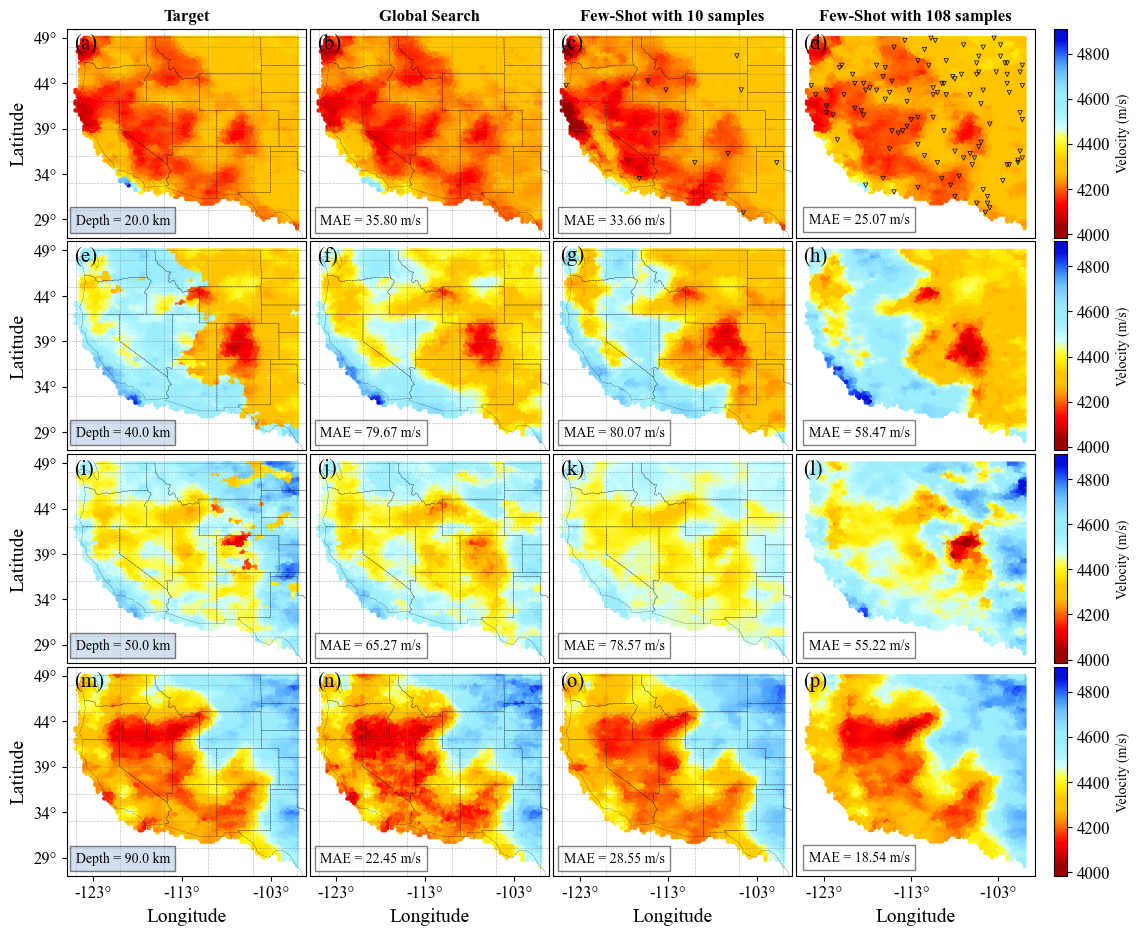

In [10]:
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import matplotlib as mpl

# Set font style and size
plt.rcParams['font.family'] = 'Times New Roman'  # Font family
plt.rcParams['font.size'] = 12  # Font size

# Load custom shapefile for coastlines
custom_shapefile_path = "./DispFormer/plot_source/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"
coastline_feature = ShapelyFeature(Reader(custom_shapefile_path).geometries(), ccrs.PlateCarree())

def add_right_cax(ax, pad, width):
    axpos = ax.get_position()
    # Ensure the colorbar height matches the height of axs[row][3]
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)
    return cax

    
def plot_rows(axs, row, depth_idx, last_row=False):
    # Determine color limits for the first two scatter plots
    vmin = np.min(target_vs[:, 1, depth_idx])*1000 - 100
    vmax = np.max(target_vs[:, 1, depth_idx])*1000 + 100
    ########################################################################
    # Scatter plot for target values
    scatter0 = axs[row][0].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=target_vs[:, 1, depth_idx]*1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    if last_row:
        axs[row][0].set_xlabel("Longitude", fontsize=14)
    else:
        axs[row][0].set_xticks([])
    axs[row][0].set_ylabel("Latitude", fontsize=14)
    axs[row][0].annotate(f"Depth = {depth_idx*0.5:.1f} km",
                            xy=(all_disp_loc[:, 0].min(), all_disp_loc[:, 1].min() +0.5),
                            xycoords='data', fontsize=10, color='black',
                            bbox=dict(facecolor='#A7C0DE', alpha=0.5, edgecolor='black'))
    
    ########################################################################
    # Scatter plot for target values
    scatter1 = axs[row][1].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=gs_inv_vs_all[:, depth_idx]*1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    if last_row:
        axs[row][1].set_xlabel("Longitude", fontsize=14)
    else:
        axs[row][1].set_xticks([])
    axs[row][1].set_yticks([])
    # Compute MAE and annotate
    
    # mae = np.mean(np.abs(target_vs_test[:, 1, depth_idx] - gs_inv_vs_test[:, depth_idx])) * 1000  # Convert to km
    mae = np.mean(np.abs(target_vs[:, 1, depth_idx] - gs_inv_vs_all[:, depth_idx])) * 1000  # Convert to km
    axs[row][1].annotate(f"MAE = {mae:.2f} m/s",
                            xy=(all_disp_loc[:, 0].min()+0.2, all_disp_loc[:, 1].min() + 0.5),
                            xycoords='data', fontsize=10, color='black',
                            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    ########################################################################
    # Scatter plot for inverted values
    scatter2 = axs[row][2].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=finetune_inv_vs500[:, depth_idx]*1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    if last_row:
        axs[row][2].set_xlabel("Longitude", fontsize=14)
    else:
        axs[row][2].set_xticks([])
    axs[row][2].set_yticks([])
    mae = np.mean(np.abs(target_vs[:, 1, depth_idx] - finetune_inv_vs500[:, depth_idx])) * 1000  # Convert to km
    axs[row][2].annotate(f"MAE = {mae:.2f} m/s",
                            xy=(all_disp_loc[:, 0].min()+0.2, all_disp_loc[:, 1].min() + 0.5),
                            xycoords='data', fontsize=10, color='black',
                            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    ########################################################################
    # Scatter plot for inverted values
    scatter3 = axs[row][3].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=finetune_inv_vs50[:, depth_idx]*1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    if last_row:
        axs[row][3].set_xlabel("Longitude", fontsize=14)
    else:
        axs[row][3].set_xticks([])
    axs[row][3].set_yticks([])

    mae = np.mean(np.abs(target_vs[:, 1, depth_idx] - finetune_inv_vs50[:, depth_idx])) * 1000  # Convert to km
    axs[row][3].annotate(f"MAE = {mae:.2f} m/s",
                            xy=(all_disp_loc[:, 0].min()+0.2, all_disp_loc[:, 1].min() + 0.5),
                            xycoords='data', fontsize=10, color='black',
                            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    ###############################################################################################################
    # automatic set the aspect
    for ax in axs[row]:
        ax.set_aspect('auto')
        
    # ########################################################################
    # Add longitude/latitude gridline and coastline feature
    for ax in axs[row][:3]:
        gl0 = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl0.top_labels      = False  # Disable top labels
        gl0.right_labels    = False  # Disable right labels
        gl0.left_labels     = False
        gl0.bottom_labels   = False
        gl0.xlabel_style    = {'size': 8, 'color': 'black'}  # Customize label style
        gl0.ylabel_style    = {'size': 8, 'color': 'black'}  # Customize label style
        
        ax.add_feature(coastline_feature, edgecolor='black', facecolor='None', linewidth=0.2, linestyle='-.')
        
        # Set extent for automatic ticks
        extent = [all_disp_loc[:, 0].min() - 1, all_disp_loc[:, 0].max() + 1,
                  all_disp_loc[:, 1].min() - 1, all_disp_loc[:, 1].max() + 1]
        ax.set_extent(extent, crs=ccrs.PlateCarree())


    # Set latitude and longitude ticks
    y_ticks_begin_shift = 1
    y_ticks_interval    = 5
    axs[row][0].set_yticks(np.arange(np.floor(all_disp_loc[:, 1].min()) + y_ticks_begin_shift,
                                      np.ceil(all_disp_loc[:, 1].max()) + 1, y_ticks_interval),
                                    crs=ccrs.PlateCarree())
    axs[row][0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))
    
    x_ticks_begin_shift = 2
    x_ticks_interval    = 10
    if last_row:
        for ax in axs[row]:
            ax.set_xticks(np.arange(np.floor(all_disp_loc[:, 0].min()) + x_ticks_begin_shift,
                                    np.ceil(all_disp_loc[:, 0].max()), x_ticks_interval),
                                  crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))

    #####################################################################
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    return sm

# Create subplots with PlateCarree projection
fig, axs = plt.subplots(4, 4, figsize=(12.5, 11), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot for different depths
plot_rows(axs, 0, 40)
axs[0][2].scatter(train_disp_loc[:, 0][::500], train_disp_loc[:, 1][::500], facecolor='None', edgecolor='k',linewidth=0.5, marker='v', s=10)
axs[0][3].scatter(train_disp_loc[:, 0][::50], train_disp_loc[:, 1][::50]  , facecolor='None', edgecolor='k',linewidth=0.5, marker='v', s=10)
plot_rows(axs, 1, 80)
plot_rows(axs, 2, 100)
sm = plot_rows(axs, 3, 180, last_row=True)


# Set titles for each column
axs[0][0].set_title( 'Target', fontsize=12, fontweight='bold')
axs[0][1].set_title( 'Global Search', fontsize=12, fontweight='bold')
axs[0][2].set_title(f'Few-Shot with {train_dataset.__len__()//500:.0f} samples', fontsize=12, fontweight='bold')
axs[0][3].set_title(f'Few-Shot with {train_dataset.__len__()//50:.0f} samples', fontsize=12, fontweight='bold')

# Adjust layout
plt.subplots_adjust(hspace=0.018, wspace=0.016)

for row in range(4):
    cax = add_right_cax(axs[row][3], pad=0.015, width=0.01)
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label('Velocity (m/s)', fontsize=10)

labels_title = ["(a)","(b)","(c)","(d)",
                "(e)","(f)","(g)","(h)",
                "(i)","(j)","(k)","(l)",
                "(m)","(n)","(o)","(p)"]
for i in range(4):
    for j in range(4):
        axs[i][j].text(0.03, 0.98, labels_title[i*4+j], transform=axs[i][j].transAxes, fontsize=15, fontweight='normal', va='top', ha='left', color='black')

plt.savefig(os.path.join(plot_base_path,"finetune_Shen2013.png"),bbox_inches='tight',dpi=300)
plt.show()

In [11]:
target_vs.shape,finetune_inv_vs500.shape,gs_inv_vs_all.shape

((6803, 2, 400), (6803, 400), (6803, 400))

In [12]:
MAE_np(target_vs[:,1,:],gs_inv_vs_all),MAE_np(target_vs[:,1,:],finetune_inv_vs500),MAE_np(target_vs[:,1,:],finetune_inv_vs50)

(42.779153121959034, 45.7022525370121, 33.84573757648468)

In [13]:
MSE_np(target_vs[:,1,:],gs_inv_vs_all),MSE_np(target_vs[:,1,:],finetune_inv_vs500),MSE_np(target_vs[:,1,:],finetune_inv_vs50)

(10.258939324323816, 6.179178599268198, 3.525474341586232)

In [14]:
MAPE_np(target_vs[:,1,:],gs_inv_vs_all),MAPE_np(target_vs[:,1,:],finetune_inv_vs500),MAPE_np(target_vs[:,1,:],finetune_inv_vs50)

(1.15963461739964, 1.1902576312422752, 0.8728030137717724)